In [42]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
import time
import nltk
from collections import Counter
from nltk.corpus import stopwords  
from nltk.tokenize import word_tokenize  
from nltk.tokenize import RegexpTokenizer
from langid.langid import LanguageIdentifier, model
import re


## Part 1/2 :  General statistics and preprocessing

In [43]:
reviews_df = pd.read_csv("groover_dataset_challenge.csv")
reviews_df

,Unnamed: 0,id,band_id,influencer_id,feedback,score
0,0,920636,24665,1642,"Bonjour Diogo Ramos,\n\n\nMerci pour le partag...",0.00
1,1,920637,24665,118,"Un message touchant, développé sur une onde mu...",0.00
2,2,920639,24665,226,Bonjour ! Merci beaucoup pour l'envoi ! On n'e...,0.00
3,3,920640,24665,1603,Bonjour. Merci pour cette fraîcheur et cet hym...,1.00
4,4,920641,24665,111,"Salut Diogo, alors c'est un peu éloigné de ce ...",1.00
...,...,...,...,...,...,...
9995,9995,936179,30049,3499,"Hey guys, thanks for sharing, great sound, alt...",1.00
9996,9996,936241,33795,2570,"Hello MD One, thank you for your track Bombe A...",0.00
9997,9997,936266,18877,2598,Hi! Thanks for sharing your track! I really li...,1.00
9998,9998,936274,18877,3179,This is an exceptionally produced electro-pop ...,0.25


we notice that the unnamed: 0 column is useless/redundant, we can also use the id column as an index

In [44]:
reviews_df = reviews_df.set_index('id').drop("Unnamed: 0",axis=1)
reviews_df

,band_id,influencer_id,feedback,score
id,,,,
920636,24665,1642,"Bonjour Diogo Ramos,\n\n\nMerci pour le partag...",0.00
920637,24665,118,"Un message touchant, développé sur une onde mu...",0.00
920639,24665,226,Bonjour ! Merci beaucoup pour l'envoi ! On n'e...,0.00
920640,24665,1603,Bonjour. Merci pour cette fraîcheur et cet hym...,1.00
920641,24665,111,"Salut Diogo, alors c'est un peu éloigné de ce ...",1.00
...,...,...,...,...
936179,30049,3499,"Hey guys, thanks for sharing, great sound, alt...",1.00
936241,33795,2570,"Hello MD One, thank you for your track Bombe A...",0.00
936266,18877,2598,Hi! Thanks for sharing your track! I really li...,1.00


we check if the data types remaining are consistent and if our dataset contains any NAs.

In [47]:
reviews_df.dtypes, reviews_df.isna().sum()  

(band_id            int64
 influencer_id      int64
 feedback          object
 score            float64
 dtype: object,
 band_id          0
 influencer_id    0
 feedback         0
 score            0
 dtype: int64)

the number of unique band and influencer IDs is < 10k so we know that we have a many to many relation (n..n) between those IDs so we should keep them 

In [48]:
len(reviews_df.band_id.unique()), len(reviews_df.influencer_id.unique())


(970, 898)

In [50]:
#dowload nltk punctuation
#run only once
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/boudokh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

we can see that the feedback texts are not in the same languages: french, english and maybe more!
we also replace the jumplines with spaces: it will make the eventual tokenisation easier 

In [51]:
reviews_df.feedback = reviews_df.feedback.apply(lambda x: re.sub(r'\n+',' ', x))
reviews_df.feedback

id
920636    Bonjour Diogo Ramos, Merci pour le partage. Ac...
920637    Un message touchant, développé sur une onde mu...
920639    Bonjour ! Merci beaucoup pour l'envoi ! On n'e...
920640    Bonjour. Merci pour cette fraîcheur et cet hym...
920641    Salut Diogo, alors c'est un peu éloigné de ce ...
                                ...                        
936179    Hey guys, thanks for sharing, great sound, alt...
936241    Hello MD One, thank you for your track Bombe A...
936266    Hi! Thanks for sharing your track! I really li...
936274    This is an exceptionally produced electro-pop ...
936392    Yo c'est pas mal ce que tu fais ! Les prod c'e...
Name: feedback, Length: 10000, dtype: object

We check that feedbacks with a score = 1 correspond to positive answer, a score = 0 is negative/refusal and 0.5 is a "maybe"

In [151]:
print(reviews_df[reviews_df.score == 1].feedback.head().values)

['Une belle voix, joliment posée sur la mélodie, mais qui manque un peu de rythme par rapport à ce que nous diffusons sur notre radio. Nous allons cependant la partager sur notre playlist Spotify, bonne continuation.'
 "Une entraînante chanson pop-urbaine à l'approche vocale masculine au ton séducteur aux saveurs latines. L'interprétation servie avec une bonne portion d'attitude fait monter le thermomètre à coup sûr avec ce titre vibrant de sonorités qui gravitent habilement autour de Reggaeton et du Dancehall avec son rythme endiablé et son alliage de musique électronique soigneusement ficelé. Voici les liens vers les playlists : https://open.spotify.com/playlist/0kWez6rGVMku0LULXSpxpm https://www.youtube.com/playlist?list=PLQQEx2JoJCJsb8ctT_lBc_2NDxf4ZI3YL"
 "Hi! Great song, I love your voice timber, it fits just right with the whole production of the song. I'm adding it to my Discover playlist, hope you enjoy it!"
 "Bonjour et merci pour le partage du titre. C'est super efficace et 

In [152]:
print(reviews_df[reviews_df.score == 0].feedback.head().values)

["Merci pour le partage et le petit mot :) Le morceau est plutôt agréable à l'oreille, mais le registre ne colle pas vraiment à notre ligne éditoriale. Le clip colle bien au titre mais la qualité de l'image pourrait être améliorée pour donner plus de crédit encore au projet. Bonne continuation à vous ! "
 'Interesting sound elements in the production. Nice beats also. However there werent many ear-catching moments in the track for me personally. Thank you for sharing.'
 "Hello Ñolo, merci pour le partage. Du rap à l'ancienne ça fait plaisir de retrouver ces sonorités, malheuresement aujourd'hui je ne développe pas de radios avec la même identité musicale. A très vite ! "
 "Song starts off pretty good, I like the overall idea of the song and the vocals are good too but overall the song is too relaxing for my gaming playlist I'm afraid. Hope you're doing good! Beau."
 'Bonjour Sacha, Nous pensons que la chanson est bonne mais la réalisation peut-être meilleure. Le mix, les lignes de chan

In [153]:
print(reviews_df[reviews_df.score == 0.5].feedback.head().values)

['Bonjour,  Merci du partage ! Je vous propose d’en parler à ma hiérarchie de Rolling Stone et voir si une prochaine inclusion dans nos playlists est possible.  Je reviendrais vers vous quelqu’en soit le retour. A très bientôt ! Sam'
 'Bonjour Julien Jefferson,  Nous avons visionné votre clip vidéo "Garder le meilleur" et allons le publier sur notre site officiel Delit Music France et nos filiales Delit Face & Info Music. Cordialement  Diane COLLET www.delitmusic.fr  www.delitface.com www.infomusic.fr '
 'Bonjour WIRDOW,  Nous avons visionné votre clip vidéo "Sourire pour te plaire" et allons le publier sur notre site officiel Delit Music France et nos filiales Delit Face && Info Music. Cordialement  Diane COLLET www.delitmusic.fr  www.infomusic.fr  www.delitface.com'
 'Bonjour,  Merci du partage ! Je vous propose d’en parler à ma hiérarchie et voir si une prochaine inclusion dans nos playlists est possible.  Je reviendrais vers vous quelqu’en soit le retour, en février. A très bientôt

In [154]:
print(reviews_df[reviews_df.score == 0.25].feedback.head().values)

['J’aime beaucoup le groove de la chanson. Le flow de votre voix est aussi très intéressant. J’aime la manière dont vous faites rimer les mots. Malheureusement ma playlist s’adresse seulement aux bands quebecois mais je vais certainement suivre votre projet!  Merci pour la découverte Emilie Xx'
 "Effectivement le morceau est efficace, on sent bien que la musique est naturelle, y'a tout ce qu'il faut pour que ça tourne !  Le clip est aussi très beau.  Ça peut faire un très bon morceau d'été ça ! Ce n'est pas vraiment dans le style de nos auditeurs, mais il est certain que ça trouvera son public ! "
 "Hello Doria ! J'espère que tu vas bien, merci pour la découverte mais malheureusement le morceau ne colle pas vraiment à ma ligne éditoriale – la rythmique inspirée du reggaeton notamment fait que je n'accroche pas au titre, et le morceau (sans critique aucune parce qu'au fond c'est plutôt un atout pour toi !) est un peu trop mainstream à mon goût Ceci dit tu as une sacrée voix, c'est impre

i chose the following tool to detect the language, it will detect the language and return the confidence of the prediction:
https://github.com/saffsd/langid.py

In [52]:
identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
reviews_df['language'] = reviews_df.feedback.apply(identifier.classify)
reviews_df[['language','lang_confidence']] = pd.DataFrame(reviews_df['language'].tolist(), index=reviews_df.index)
reviews_df

,band_id,influencer_id,feedback,score,language,lang_confidence
id,,,,,,
920636,24665,1642,"Bonjour Diogo Ramos, Merci pour le partage. Ac...",0.00,fr,1.0
920637,24665,118,"Un message touchant, développé sur une onde mu...",0.00,fr,1.0
920639,24665,226,Bonjour ! Merci beaucoup pour l'envoi ! On n'e...,0.00,fr,1.0
920640,24665,1603,Bonjour. Merci pour cette fraîcheur et cet hym...,1.00,fr,1.0
920641,24665,111,"Salut Diogo, alors c'est un peu éloigné de ce ...",1.00,fr,1.0
...,...,...,...,...,...,...
936179,30049,3499,"Hey guys, thanks for sharing, great sound, alt...",1.00,en,1.0
936241,33795,2570,"Hello MD One, thank you for your track Bombe A...",0.00,en,1.0
936266,18877,2598,Hi! Thanks for sharing your track! I really li...,1.00,en,1.0


In [53]:
reviews_df.isna().sum(), reviews_df.dtypes #check that we split the tuples crrectly and we have no NAs

(band_id            0
 influencer_id      0
 feedback           0
 score              0
 language           0
 lang_confidence    0
 dtype: int64,
 band_id              int64
 influencer_id        int64
 feedback            object
 score              float64
 language            object
 lang_confidence    float64
 dtype: object)

overall the language prediction confidence is quite high, only 4 items below 98%, but there's a clearly mislabeled portuguese(?) comment labeled 'fr'

In [54]:
reviews_df[reviews_df.lang_confidence < 0.98]

,band_id,influencer_id,feedback,score,language,lang_confidence
id,,,,,,
925439,12412,2101,"Olá Santos, tudo bem com você? Gostei muito...",0.25,pt,0.944387
926426,9241,2101,"Olá QLAPs, tudo bem com você? Gostei muito do ...",0.25,fr,0.906224
928037,8063,2101,"Olá Franck Dansaert, tudo bem com você? Gostei...",0.25,br,0.900079
932044,33835,2501,"HELLO PRO STREAM, HOW ARE U? HOPE THAT U ARE G...",0.25,en,0.963665


481 items are neither french nor english 

In [55]:
reviews_df[~reviews_df.language.isin(['fr','en'])]


,band_id,influencer_id,feedback,score,language,lang_confidence
id,,,,,,
920676,29872,737,"Hola socio es un placer saludarte, he escuchad...",0.25,es,1.0
920754,32440,2765,"Ciao, grazie per averci inviato il vostro pezz...",0.00,it,1.0
920840,23712,2000,Ciao sono Marco Racchella MRP75 direttore arti...,0.50,it,1.0
920974,33092,2000,Ciao sono Marco Racchella MRP75 direttore arti...,0.50,it,1.0
920980,30813,3092,"Sono passati i 7 giorni? Scherzi a parte, hai ...",0.25,it,1.0
...,...,...,...,...,...,...
934936,27682,3334,"Ciao, il pezzo è davvero forte! Ci piace molto...",1.00,it,1.0
935599,32752,3008,"Ciao Pierfrancesco, innanzitutto complimenti p...",1.00,it,1.0
935870,29867,2043,Que voz incrível. Estamos fascinados! Com tod...,1.00,pt,1.0


<AxesSubplot:xlabel='language', ylabel='Count'>

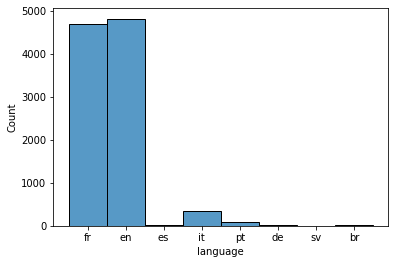

In [56]:
sns.histplot(data=reviews_df, x="language")

we only keep the french and english comments and only those with a prediction confidence above 98%

In [57]:
reviews_df = reviews_df[reviews_df.language.isin(['fr','en'])]
reviews_df = reviews_df[reviews_df.lang_confidence > 0.98]
reviews_df.language = reviews_df.language.astype("category")
reviews_df

,band_id,influencer_id,feedback,score,language,lang_confidence
id,,,,,,
920636,24665,1642,"Bonjour Diogo Ramos, Merci pour le partage. Ac...",0.00,fr,1.0
920637,24665,118,"Un message touchant, développé sur une onde mu...",0.00,fr,1.0
920639,24665,226,Bonjour ! Merci beaucoup pour l'envoi ! On n'e...,0.00,fr,1.0
920640,24665,1603,Bonjour. Merci pour cette fraîcheur et cet hym...,1.00,fr,1.0
920641,24665,111,"Salut Diogo, alors c'est un peu éloigné de ce ...",1.00,fr,1.0
...,...,...,...,...,...,...
936179,30049,3499,"Hey guys, thanks for sharing, great sound, alt...",1.00,en,1.0
936241,33795,2570,"Hello MD One, thank you for your track Bombe A...",0.00,en,1.0
936266,18877,2598,Hi! Thanks for sharing your track! I really li...,1.00,en,1.0


Now we explore the scores column, 4 unique values from 0 to 1, (no 0.75 scores though) and 0 is unfortunatly for the artist by far the most common score, but it's probably consistent with the reality of the music industry.

In [58]:
unique, counts = np.unique(reviews_df.score, return_counts=True)
unique, counts

(array([0.  , 0.25, 0.5 , 1.  ]), array([6203,  991,  155, 2168]))

<AxesSubplot:>

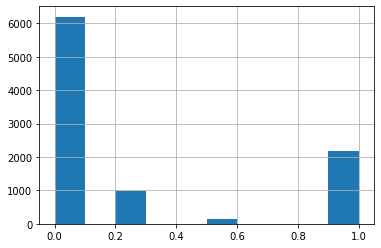

In [59]:
reviews_df.score.hist()

In [60]:
reviews_df['word_count'] = reviews_df.feedback.apply(lambda x: len(x.split()))
reviews_df['char_count'] = reviews_df.feedback.apply(lambda x: len(x))
reviews_df[['char_count','word_count','score']].describe()

,char_count,word_count,score
count,9517.000000,9517.000000,9517.000000
mean,286.355469,49.460019,0.261979
std,256.265562,43.021933,0.412029
min,71.000000,16.000000,0.000000
25%,156.000000,27.000000,0.000000
50%,218.000000,38.000000,0.000000
75%,334.000000,58.000000,0.250000
max,4603.000000,774.000000,1.000000


<AxesSubplot:xlabel='char_count', ylabel='Count'>

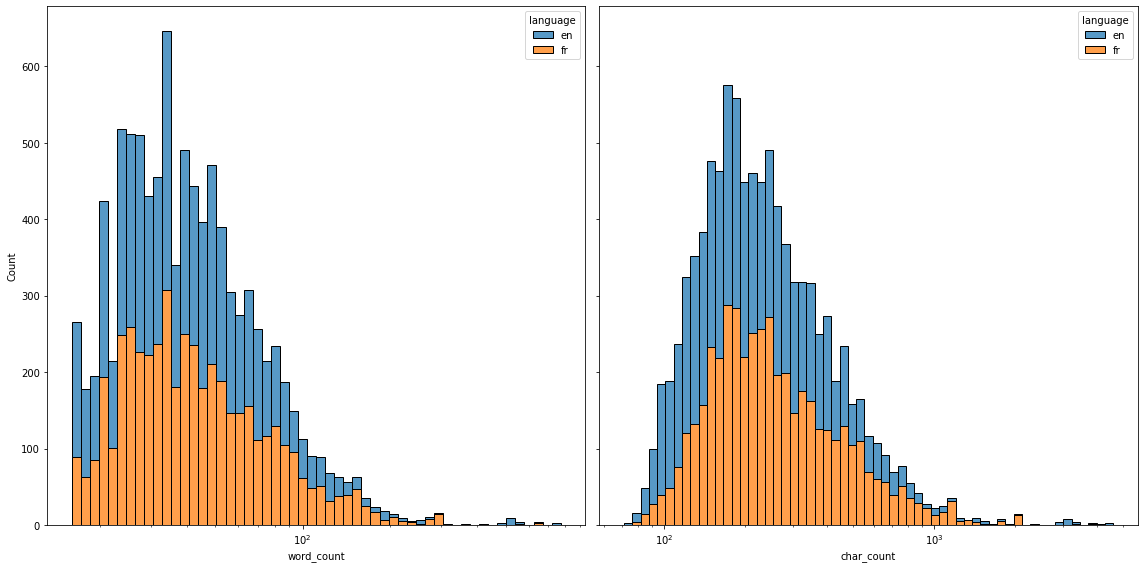

In [61]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize=(16, 8))
sns.histplot(data=reviews_df, x="word_count",  ax=axs[0], log_scale=True, hue='language', multiple="stack")
sns.histplot(data=reviews_df, x="char_count",  ax=axs[1], log_scale=True, hue='language', multiple="stack")


[(0.0, 200.0)]

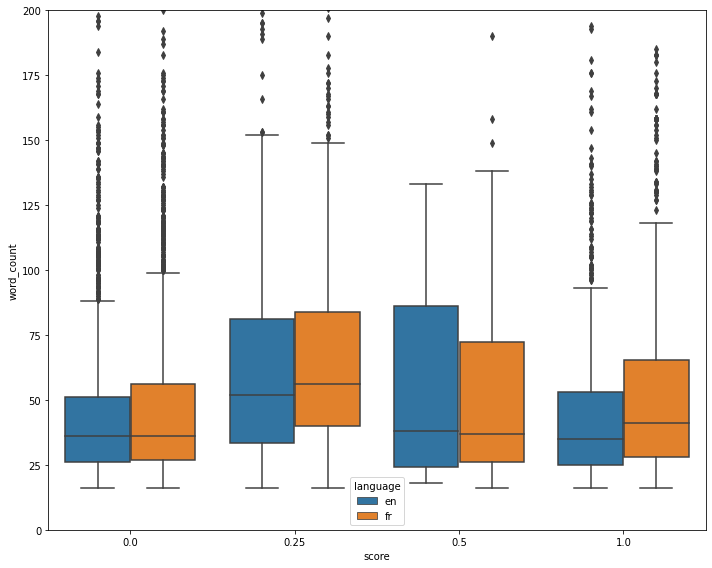

In [62]:
fig, axs = plt.subplots(sharey=True, tight_layout=True, figsize=(10, 8))
g = sns.boxplot(y="word_count", x = "score",
                hue="language",
                data=reviews_df)
g.set(ylim=(0, 200))

We don't have a significant disparity between the length of the feedbacks depending on the language or the score for the scores 0 and 1. 

for 0.25 and 0.5 scores we can't draw any conlusions due to the small sample size.



all the comments in the data set respect the minimum 15 words per feedback rule!

In [156]:
reviews_df[reviews_df.word_count < 15]

,band_id,influencer_id,feedback,score,language,lang_confidence,word_count,char_count,lemma
id,,,,,,,,,


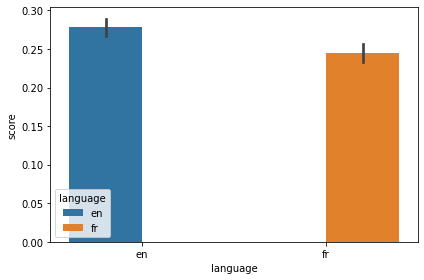

In [63]:
fig, axs = plt.subplots(sharey=True, tight_layout=True, figsize=(6, 4))
g = sns.barplot(y="score", x="language",
                hue="language",
                data=reviews_df)


The english comments seem slightly more positive

In [64]:
full_corpus = word_tokenize(" ".join(reviews_df.feedback.tolist()))
word_occurences = Counter(full_corpus)
word_occurences.most_common(20)

[('.', 23811),
 (',', 23518),
 ('the', 10371),
 ('!', 8832),
 ('de', 7804),
 ('a', 6639),
 ('and', 5972),
 ('I', 5679),
 ('to', 5364),
 ('for', 5175),
 ('et', 4784),
 ('pour', 4755),
 ('le', 4457),
 ('à', 4329),
 ('la', 4229),
 ('you', 4059),
 ('it', 3870),
 ('of', 3579),
 ('pas', 3502),
 ('is', 3443)]

we observe that the most common tokens in our feedbacks contain many punctuations and stop words, our next task is to clean them and lowercase all our tokens.

In [65]:
full_corpus = [w.lower() for w in full_corpus if w.isalpha()]
word_occurences = Counter(full_corpus)
word_occurences.most_common(20)

[('the', 11736),
 ('de', 7903),
 ('a', 7307),
 ('i', 6418),
 ('and', 6036),
 ('to', 5415),
 ('le', 5407),
 ('for', 5269),
 ('pour', 5022),
 ('et', 4890),
 ('la', 4749),
 ('à', 4512),
 ('it', 4512),
 ('you', 4324),
 ('of', 3594),
 ('pas', 3581),
 ('on', 3527),
 ('nous', 3512),
 ('is', 3464),
 ('un', 3446)]

In [66]:
word_occurences_df = pd.DataFrame.from_dict(word_occurences, columns=['occurences'], orient='index').sort_values(by=['occurences'], ascending=False)

stop_words_en = set(stopwords.words('english'))
stop_words_fr = set(stopwords.words('french'))
stop_words={'en':stop_words_en, 'fr':stop_words_fr}

stop_words_full = stop_words_en.union(stop_words_fr)
word_occurences_df['is_stop_word'] = word_occurences_df.index.to_series().apply(lambda x: True if x in stop_words_full else False)
word_occurences_df

,occurences,is_stop_word
the,11736,True
de,7903,True
a,7307,True
i,6418,True
and,6036,True
...,...,...
bonjur,1,False
ambiançant,1,False
cristallin,1,False
cossett,1,False


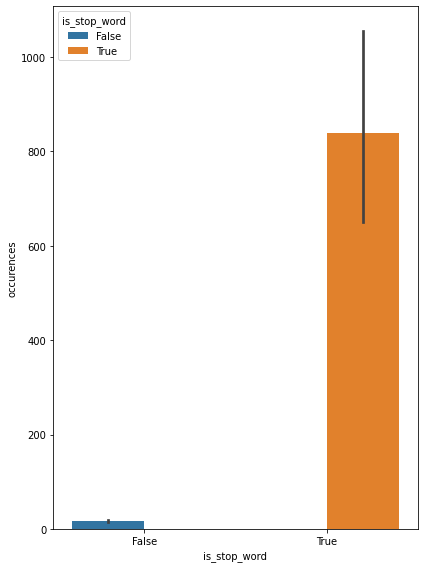

In [67]:
fig, axs = plt.subplots(sharey=True, tight_layout=True, figsize=(6, 8))
g = sns.barplot(y="occurences", x="is_stop_word",
                hue="is_stop_word",
                data=word_occurences_df)

as expected the average occurence of stop words is much higher than the rest of the words

Our next step of pre-processing is to vectorize our feedback. 
Usually for these datasets the best option is a TF-IDF vectorizer, it will account for the frequency of each word in the feedback normalized by the occurence of the said word in the whole dataset

we have to first tokenize each feedback individually and then since this data is probably used to predict the score based on the feedback, lemmatization and stemming are usually useful tools for such classification and sentiment analysis. 

I opted for lemmatization since stemming is usually more "agressive" as it only keep a less precise root and we may lose meaning while lemmatization is slower but can wield more precise results, our dataset is quite small so it shouldn't take more than a minute. for a longer dataset, stemming could have the better option.

I chose Spacy going forward because they have a french lemmatizer unlike NLTK.

In [84]:
import spacy
import unidecode

nlp_fr = spacy.load('fr_core_news_sm')
nlp_en = spacy.load('en_core_web_sm')


In [85]:
def lemmatize(text, language):
    if language is 'fr':
        doc = nlp_fr(str(text))
    else:
        doc = nlp_en(str(text))
    return [w.lemma_ for w in doc if (not w.is_stop and not w.is_punct and not w.like_num)]

In [87]:
reviews_df['lemma'] = reviews_df.apply(lambda x: lemmatize(x.feedback, x.language), axis=1)
reviews_df

,band_id,influencer_id,feedback,score,language,lang_confidence,word_count,char_count,lemma
id,,,,,,,,,
920636,24665,1642,"Bonjour Diogo Ramos, Merci pour le partage. Ac...",0.00,fr,1.0,31,199,"[bonjour, diogo, ramos, merci, pour, le, parta..."
920637,24665,118,"Un message touchant, développé sur une onde mu...",0.00,fr,1.0,30,202,"[un, message, touchant, developpe, sur, une, o..."
920639,24665,226,Bonjour ! Merci beaucoup pour l'envoi ! On n'e...,0.00,fr,1.0,21,122,"[bonjour, merci, beaucoup, pour, l'envoi, n'es..."
920640,24665,1603,Bonjour. Merci pour cette fraîcheur et cet hym...,1.00,fr,1.0,28,183,"[bonjour, merci, pour, cette, fraicheur, et, c..."
920641,24665,111,"Salut Diogo, alors c'est un peu éloigné de ce ...",1.00,fr,1.0,41,213,"[salut, diogo, alor, c'est, un, peu, eloigne, ..."
...,...,...,...,...,...,...,...,...,...
936179,30049,3499,"Hey guys, thanks for sharing, great sound, alt...",1.00,en,1.0,33,178,"[hey, guy, thank, sharing, great, sound, find,..."
936241,33795,2570,"Hello MD One, thank you for your track Bombe A...",0.00,en,1.0,127,655,"[hello, md, thank, track, bombe, a., certainly..."
936266,18877,2598,Hi! Thanks for sharing your track! I really li...,1.00,en,1.0,31,161,"[hi, thank, share, track, like, song, give, go..."


## Part 3 :  Fitting and vectorization

In [88]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn import svm
from sklearn.pipeline import make_pipeline


The first thing to do is to shuffle the data to have the same distribution when we eventually split the training and validation datasets. We also separate the attribute that we wish to predict, the score in our case. then we transform the score into int by multiplying by four and converting to ints.

In [139]:
reviews_df = shuffle(reviews_df) 

x = reviews_df.drop(["score"], axis=1)
y = (reviews_df["score"]*4).astype('int')

X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.25, random_state=42)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape


((7137, 8), (7137,), (2380, 8), (2380,))

we make sure that our validation and training datasets are evenly distributed.
we check the distribution plot of the scores and histplots to compare the distribution of the languages.

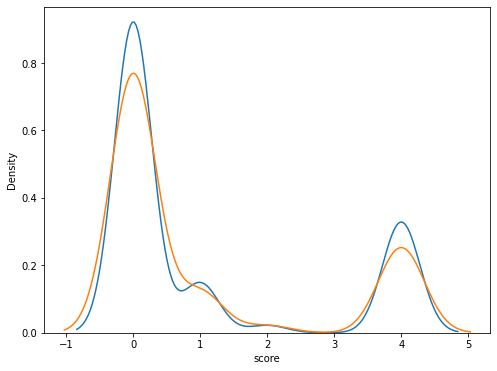

In [115]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
sns.distplot(y_train, hist=False)
sns.distplot(y_valid, hist=False)
plt.show()


<AxesSubplot:xlabel='language', ylabel='Count'>

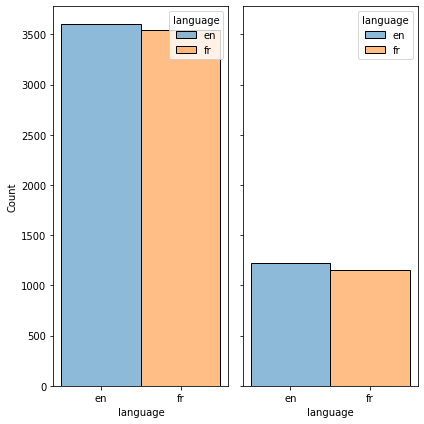

In [116]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize=(6, 6))
sns.histplot(data=X_train, x="language", ax=axs[0], hue='language')
sns.histplot(data=X_valid, x="language", ax=axs[1], hue='language')

I decided to only keep the lemmatized feedback and that language, i could't see how to transform the band_id and influencer_id into features. 
for the feature engineering part i opted for TF-idf for our text and one hot encoding for the language since it's a categorical attribute

In [140]:
feature_engineering = ColumnTransformer(
         [('language', OneHotEncoder(dtype='int', handle_unknown = 'ignore'),['language']),
          ('lemma', TfidfVectorizer(max_features=10000,
                            tokenizer=lambda x: x,
                            lowercase=False), 'lemma')],
         remainder='drop')
X_train_tfidf = feature_engineering.fit_transform(X_train)
X_valid_tfidf = feature_engineering.transform(X_valid)

now it's time for training the model!
i opted for some simple architechtures but with such a small dataset (only 10k lines) we shouldn't expect a massive accuracy

## Gradient boosting is currently the best classifier that i found with weighted scoring metrics around 85% with not bad considering it's a mixed language model and a relatively small dataset

In [141]:
gb_classifier = GradientBoostingClassifier(n_estimators=200, max_depth=10)
gb_classifier.fit(X_train_tfidf, y_train.values)


GradientBoostingClassifier(max_depth=10, n_estimators=200)

In [142]:
y_gb_pred = pd.DataFrame(gb_classifier.predict(X_valid_tfidf))

print(classification_report(y_valid, y_gb_pred))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1542
           1       0.73      0.38      0.50       231
           2       0.82      0.64      0.72        44
           4       0.87      0.77      0.82       563

    accuracy                           0.86      2380
   macro avg       0.82      0.69      0.74      2380
weighted avg       0.85      0.86      0.84      2380



In [145]:
svm_classifier = make_pipeline(StandardScaler(with_mean=False), svm.SVC(gamma='auto'))
svm_classifier.fit(X_train_tfidf, y_train.values)


Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('svc', SVC(gamma='auto'))])

In [146]:
y_svm_pred = pd.DataFrame(svm_classifier.predict(X_valid_tfidf))

print(classification_report(y_valid, y_svm_pred))

              precision    recall  f1-score   support

           0       0.75      0.99      0.86      1542
           1       0.97      0.16      0.28       231
           2       0.95      0.41      0.57        44
           4       0.95      0.49      0.65       563

    accuracy                           0.78      2380
   macro avg       0.91      0.51      0.59      2380
weighted avg       0.82      0.78      0.75      2380

